# 학습

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [2]:
import tensorflow as tf
# tf.debugging.set_log_device_placement(True) # 활성화 시 연산이 어떤 장치(cpu, gpu)에서 실행되는지 로그를 출력해줌(로그 출력은 성능을 많이 사용하니 주의)
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[2], 'GPU')
tf.config.set_logical_device_configuration(gpus[2], [tf.config.LogicalDeviceConfiguration(memory_limit=12*1024)])  # vram 12GB 할당, 필요에 따라 조절
logical_gpus = tf.config.list_logical_devices('GPU')
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")

2024-04-02 10:25:26.143874: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 10:25:26.143900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 10:25:26.145268: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-02 10:25:26.151656: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate c

4 Physical GPUs, 1 Logical GPU


2024-04-02 10:25:27.194112: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12288 MB memory:  -> device: 2, name: NVIDIA L40S, pci bus id: 0000:ca:00.0, compute capability: 8.9


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
train_dir = "/home/j-j10a205/Data/herb/training/image/lanczos/"
validation_dir = "/home/j-j10a205/Data/herb/validation/image/lanczos/"
IMG_SIZE = (224, 224)
BATCH_SIZE = 64

In [5]:
# 사전학습된 mobilet net v3 로드
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

2024-04-02 10:25:30.578796: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1101] failed to allocate 12.00GiB (12884901888 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-04-02 10:25:30.579023: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1101] failed to allocate 10.80GiB (11596410880 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


In [6]:
# base_model.summary()

In [7]:
len(base_model.layers)

263

In [8]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    image_size=IMG_SIZE,
    shuffle=True,
    batch_size=BATCH_SIZE
)

Found 530254 files belonging to 128 classes.


2024-04-02 10:25:40.920484: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [9]:
validation_data_origin = tf.keras.utils.image_dataset_from_directory(
    validation_dir, 
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    image_size=IMG_SIZE,
    shuffle=True,
    batch_size=BATCH_SIZE
)

Found 66246 files belonging to 128 classes.


In [10]:
validation_data_origin.class_names == train_data.class_names

True

In [18]:
result_class = validation_data_origin.class_names

In [65]:
import pickle as pk

with open('result.pkl','wb') as f:
    pk.dump(result_class, f)

In [12]:
# validation data와 test data 분리
val_batches = tf.data.experimental.cardinality(validation_data_origin)
test_data = validation_data_origin.take(val_batches // 5)
validation_data = validation_data_origin.skip(val_batches // 5)

In [13]:
AUTOTUNE = tf.data.AUTOTUNE    # -1
# 학습 진행되는 동안 다음 데이터를 미리 로드하도록 설정
train_dataset = train_data.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_data.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_data.prefetch(buffer_size=AUTOTUNE)

In [14]:
# 학습 이미지를 뒤집고, 회전시켜서 다양한 학습이 가능하도록 설정
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal'), tf.keras.layers.RandomRotation(0.2)])

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(128, activation='sigmoid')

In [22]:
# 특징 확인
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
dense_batch = tf.keras.layers.Dense(512, activation='relu')(feature_batch)
print(dense_batch.shape)
feature_batch_average = global_average_layer(dense_batch)
print(feature_batch_average.shape)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 7, 7, 960)
(64, 7, 7, 512)
(64, 512)
(64, 128)


In [23]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x1 = data_augmentation(inputs)
x1 = base_model(x1, training=False)
x1 = tf.keras.layers.Dense(512, activation='relu')(x1)
x1 = global_average_layer(x1)
x1 = tf.keras.layers.Dropout(0.5)(x1)
outputs = prediction_layer(x1)
model1 = tf.keras.Model(inputs, outputs)

In [24]:
base_learning_rate = 0.0001
model1.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [25]:
initial_epochs = 10
checkpoint_path = '/home/j-j10a205/checkpoints/v2/checkpoint'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

In [26]:
history = model1.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset, callbacks=[cp_callback])

Epoch 1/10
8286/8286 [==============================] - ETA: 0s - loss: 1.2868 - accuracy: 0.6763
Epoch 1: saving model to /home/j-j10a205/checkpoints/v2/checkpoint
8286/8286 [==============================] - 971s 115ms/step - loss: 1.2868 - accuracy: 0.6763 - val_loss: 0.5110 - val_accuracy: 0.8552
Epoch 2/10
8285/8286 [============================>.] - ETA: 0s - loss: 0.4620 - accuracy: 0.8705
Epoch 2: saving model to /home/j-j10a205/checkpoints/v2/checkpoint
8286/8286 [==============================] - 938s 113ms/step - loss: 0.4620 - accuracy: 0.8705 - val_loss: 0.3109 - val_accuracy: 0.9103
Epoch 3/10
8285/8286 [============================>.] - ETA: 0s - loss: 0.3023 - accuracy: 0.9136
Epoch 3: saving model to /home/j-j10a205/checkpoints/v2/checkpoint
8286/8286 [==============================] - 711s 86ms/step - loss: 0.3023 - accuracy: 0.9136 - val_loss: 0.2657 - val_accuracy: 0.9235
Epoch 4/10
8285/8286 [============================>.] - ETA: 0s - loss: 0.2235 - accuracy: 0.93

In [27]:
model_path = '/home/j-j10a205/v2/model'
model1.save(model_path)

INFO:tensorflow:Assets written to: /home/j-j10a205/v2/model/assets


INFO:tensorflow:Assets written to: /home/j-j10a205/v2/model/assets


In [28]:
weights_path = '/home/j-j10a205/v2/weights/weights'
model1.save_weights(weights_path)

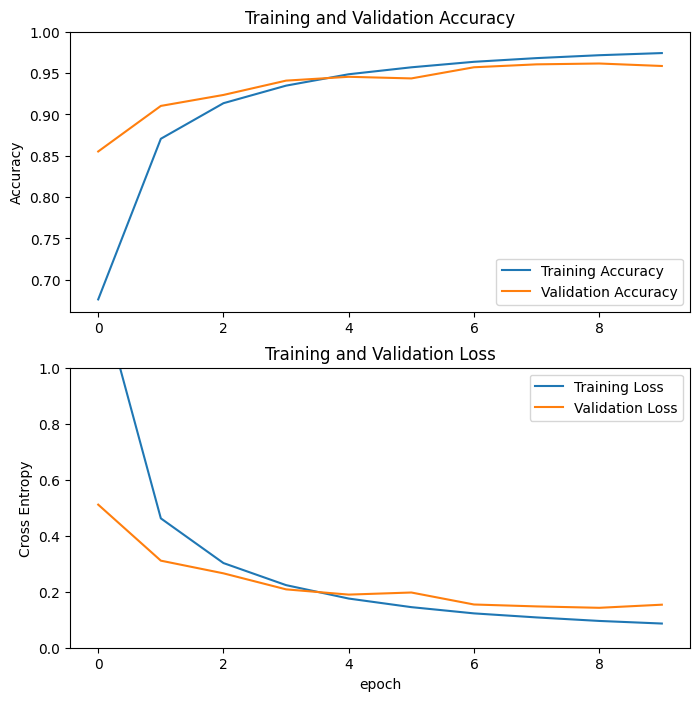

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
loss0, accuracy0 = model1.evaluate(test_dataset)

207/207 [==============================] - 3s 15ms/step - loss: 0.1402 - accuracy: 0.9593


In [8]:
del base_model
del model1

NameError: name 'base_model' is not defined

# 서비스

In [11]:
model_load_path = '/home/j-j10a205/v2/model'
model1 = tf.keras.models.load_model(model_load_path)

In [59]:
test_img_path2 = '/home/j-j10a205/down.jpg'
INTERPOLATION = 'lanczos3'
# 이미지 읽어오기
image3 = tf.io.read_file(test_img_path2)
image3 = tf.io.decode_image(image3, channels=3)

# 이미지 리사이즈
image3 = tf.image.resize(image3, IMG_SIZE, method=INTERPOLATION)

# predict에 활용하기 위한 차원 변경
image4 = image3[tf.newaxis, ...]
image4.shape

TensorShape([1, 224, 224, 3])

In [60]:
test_result2 = model1.predict(image4).flatten()

1/1 [==============================] - 0s 309ms/step


In [61]:
test_enumerate2 = list(enumerate(test_result2))
test_enumerate2.sort(key=lambda x: -x[1])
test_enumerate2 = list(map(lambda x: (x[0], round(x[1], 12)), test_enumerate2))

In [62]:
test_enumerate2

[(20, 0.99706584),
 (19, 0.924121),
 (23, 0.4687734),
 (108, 0.27852005),
 (14, 0.023745295),
 (40, 0.015766082),
 (119, 0.0019755794),
 (82, 0.001805473),
 (97, 0.0011713377),
 (76, 0.00073330686),
 (99, 0.0006964354),
 (47, 0.0005029955),
 (25, 0.00045550888),
 (10, 0.0004392833),
 (98, 0.00037118385),
 (68, 0.00032307222),
 (17, 0.00026939285),
 (31, 0.00018726064),
 (102, 0.00018598816),
 (80, 8.398171e-05),
 (105, 5.739854e-05),
 (21, 4.9956576e-05),
 (34, 4.578979e-05),
 (9, 3.6639613e-05),
 (83, 2.971556e-05),
 (46, 2.1471082e-05),
 (5, 2.0479585e-05),
 (74, 1.8982844e-05),
 (71, 1.762535e-05),
 (77, 1.4350704e-05),
 (4, 1.3943012e-05),
 (64, 1.3707045e-05),
 (104, 1.1303966e-05),
 (11, 1.0575361e-05),
 (12, 8.701967e-06),
 (15, 6.783792e-06),
 (54, 6.778269e-06),
 (95, 5.732368e-06),
 (78, 5.363671e-06),
 (81, 4.839648e-06),
 (16, 4.7405e-06),
 (49, 4.698714e-06),
 (18, 4.578558e-06),
 (88, 4.339008e-06),
 (52, 4.024437e-06),
 (43, 3.884952e-06),
 (41, 3.342859e-06),
 (63, 3.08

In [63]:
result_class[20]

'023_파(실파)'

In [64]:
result_class[19]

'022_부추'

test_img_path3 = '/home/j-j10a205/test.PNG'
INTERPOLATION = 'lanczos3'
# 이미지 읽어오기
image5 = tf.io.read_file(test_img_path3)
image5 = tf.io.decode_image(image5, channels=3)

# 이미지 리사이즈
image5 = tf.image.resize(image5, IMG_SIZE, method=INTERPOLATION)

# predict에 활용하기 위한 차원 변경
image6 = image5[tf.newaxis, ...]
image6.shape

In [45]:
test_result3 = model1.predict(image6).flatten()

1/1 [==============================] - 0s 17ms/step


In [46]:
test_enumerate3 = list(enumerate(test_result3))
test_enumerate3.sort(key=lambda x: -x[1])
test_enumerate3 = list(map(lambda x: (x[0], round(x[1], 12)), test_enumerate3))

In [47]:
test_enumerate3

[(73, 0.95535564),
 (107, 0.015985712),
 (119, 0.010034647),
 (60, 0.0034036103),
 (74, 0.0016388617),
 (105, 0.0015613775),
 (1, 0.0008447312),
 (37, 0.0006726951),
 (18, 0.00062107603),
 (54, 0.00043939683),
 (0, 0.0003241854),
 (106, 0.0003151964),
 (96, 0.00023712717),
 (39, 0.00019854451),
 (10, 0.00016603402),
 (65, 0.00015134052),
 (38, 0.0001360104),
 (11, 0.00011677126),
 (67, 7.523816e-05),
 (49, 7.100092e-05),
 (2, 6.783808e-05),
 (41, 4.7654918e-05),
 (124, 4.5266574e-05),
 (123, 4.4323275e-05),
 (118, 4.055163e-05),
 (8, 3.6873724e-05),
 (100, 3.4631383e-05),
 (27, 2.3377515e-05),
 (108, 2.3132461e-05),
 (104, 1.9639167e-05),
 (3, 1.9457313e-05),
 (44, 1.8621922e-05),
 (15, 1.4016591e-05),
 (12, 1.3621105e-05),
 (87, 1.2930324e-05),
 (89, 1.1223746e-05),
 (98, 9.90025e-06),
 (76, 8.749474e-06),
 (51, 6.881446e-06),
 (48, 6.221979e-06),
 (16, 5.76052e-06),
 (75, 5.554499e-06),
 (7, 5.239536e-06),
 (64, 4.984596e-06),
 (61, 4.506762e-06),
 (40, 4.498398e-06),
 (45, 3.916572e

In [48]:
result_class[73]

'079_오미자'

# 모델압축

In [66]:
import shutil
shutil.make_archive('/home/j-j10a205/v2/modelv2', 'zip', '/home/j-j10a205/v2/model')

'/home/j-j10a205/v2/modelv2.zip'